In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline


from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))

metadata.csv
sample_submission.csv.zip
test
train
train_masks
train_masks.csv



In [3]:
# set the necessary directories
data_dir = "../data/train/"
mask_dir = "../data/train_masks/"
all_images = os.listdir(data_dir)

In [5]:
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

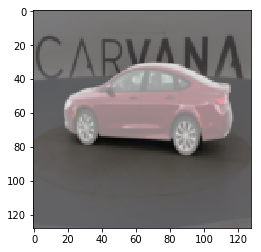

In [7]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, [128, 128])
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [8]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [9]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [128, 128, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 64, 64, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [12]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [13]:
# Training time!
# probably need to play around a little bit with the learning rate to get it to start learning
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
model.fit_generator(train_gen, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 34s - loss: 0.2771 - dice_coef: 0.5290    
Epoch 2/10
100/100 [==============================] - 34s - loss: 0.0851 - dice_coef: 0.9177    
Epoch 3/10
100/100 [==============================] - 35s - loss: 0.0658 - dice_coef: 0.9373    
Epoch 4/10
100/100 [==============================] - 35s - loss: 0.0596 - dice_coef: 0.9435    
Epoch 5/10
100/100 [==============================] - 35s - loss: 0.0407 - dice_coef: 0.9612    
Epoch 6/10
100/100 [==============================] - 35s - loss: 0.0419 - dice_coef: 0.9630    
Epoch 7/10
100/100 [==============================] - 35s - loss: 0.0386 - dice_coef: 0.9650    
Epoch 8/10
100/100 [==============================] - 35s - loss: 0.0330 - dice_coef: 0.9704    
Epoch 9/10
100/100 [==============================] - 35s - loss: 0.0295 - dice_coef: 0.9740    
Epoch 10/10
100/100 [==============================] - 35s - loss: 0.0278 - dice_coef: 0.9760    


In [87]:
def _rle_encode(img):
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]

    return ' '.join(str(x) for x in runs)


def _rle_decode(mask_rle, shape):
    s = mask_rle.split()

    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape)

In [20]:
submission = pd.read_csv('../data/sample_submission.csv')

In [81]:
def data_gen_small_test(data_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            for i in range(0, len(images), batch_size):
                imgs = []
                labels = []
                for j in range(i, i+batch_size):
                    # images
                    original_img = load_img(data_dir + images[j])
                    resized_img = imresize(original_img, dims+[3])
                    array_img = img_to_array(resized_img)/255
                    imgs.append(array_img)

                imgs = np.array(imgs)
                yield imgs

In [82]:
# set the necessary directories
data_dir = "../data/test/"
test_images = submission['img'].values.tolist()

In [83]:
test_gen = data_gen_small_test(data_dir, test_images, 32, [128, 128])
sub = model.predict_generator(test_gen,
                        len(test_images)//32,
                        max_queue_size=32,
                        workers=1,
                        use_multiprocessing=False,
                        verbose=1)

3127/3127 [==============================] - 3996s  


In [84]:
dims = [128, 128]
original_img = load_img(data_dir + test_images[2])
resized_img = imresize(original_img, dims+[3])
array_img = img_to_array(resized_img)/255

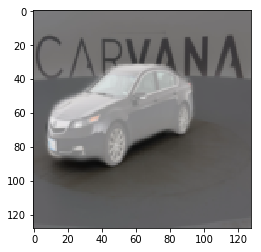

In [85]:
plt.imshow(array_img)
plt.imshow(grey2rgb(sub[2]), alpha=0.5)

In [88]:
for mask in sub:
    # resize
    # RLE
    # iloc[i].rle_mask
    # submission.iloc[i]['rle_mask']

'2 1 4 1 6 1 8 1 10 1 12 1 14 1 16 1 18 1 20 1 22 1 24 1 26 1 28 1 30 1 32 1 34 1 36 1 38 1 40 1 42 1 44 1 46 1 48 1 50 1 52 1 54 1 56 1 58 1 60 1 62 1 64 1 66 1 68 1 70 1 72 1 74 1 76 1 78 1 80 1 82 1 84 1 86 1 88 1 90 1 92 1 94 1 96 1 98 1 100 1 102 1 104 1 106 1 108 1 110 1 112 1 114 1 116 1 118 1 120 1 122 1 124 1 126 1 128 1 130 1 132 1 134 1 136 1 138 1 140 1 142 1 144 1 146 1 148 1 150 1 152 1 154 1 156 1 158 1 160 1 162 1 164 1 166 1 168 1 170 1 172 1 174 1 176 1 178 1 180 1 182 1 184 1 186 1 188 1 190 1 192 1 194 1 196 1 198 1 200 1 202 1 204 1 206 1 208 1 210 1 212 1 214 1 216 1 218 1 220 1 222 1 224 1 226 1 228 1 230 1 232 1 234 1 236 1 238 1 240 1 242 1 244 1 246 1 248 1 250 1 252 1 254 1 256 1 258 1 260 1 262 1 264 1 266 1 268 1 270 1 272 1 274 1 276 1 278 1 280 1 282 1 284 1 286 1 288 1 290 1 292 1 294 1 296 1 298 1 300 1 302 1 304 1 306 1 308 1 310 1 312 1 314 1 316 1 318 1 320 1 322 1 324 1 326 1 328 1 330 1 332 1 334 1 336 1 338 1 340 1 342 1 344 1 346 1 348 1 350 1 35

In [90]:
submission.iloc[0]['rle_mask'] = 0

In [92]:
submission

,img,rle_mask
0,0004d4463b50_01.jpg,0
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1
5,0004d4463b50_06.jpg,1 1
6,0004d4463b50_07.jpg,1 1
7,0004d4463b50_08.jpg,1 1
8,0004d4463b50_09.jpg,1 1
9,0004d4463b50_10.jpg,1 1
